<a href="https://colab.research.google.com/github/Muntasir2179/pytorch-learnig/blob/model-deployment/09_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch model deployment

What is model deployment?
> Machine learning model deployment is the act of making the model available to someone or something else.


## 0.0 Get setup

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 4036 (delta 1067), reused 1080 (delta 995), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.50 MiB | 38.83 MiB/s, done.
Resolving deltas: 100% (2360/2360), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1.0 Get the dataset (pizza, steak, shushi 20%)

In [3]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [4]:
# setting up traing and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2.0 FoodVision Mini model deployment experiment outline

### 3 questions
1. What is my most ideal machine learning model deployment scenatio?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast.

* Performs well: 94%+ accuracy.
* Fast: As close to real-time (or faster) as possible (30FPS+ or 30ms latency)

  * Latency = time for prediction to take place

To try and achieve these goals, we're going to build two model experiments:

1. EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking).
2. ViT feature extractor (just like in 08. PyTorch paper replicating).

## 3.0 Creating a EffNetB2 feature extractor

In [5]:
# disabling the hash code checking while loading the pretrained models by overriding the get_state_dict() funciton
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

In [6]:
# function for freezing the base layers
def freez_base_layers(model: torch.nn.Module,
                      num_classes: int):
  # freezing the layers
  for param in model.parameters():
    param.requires_grad = False

  # confugure the output layer
  set_seeds()
  feature_numbers = model.classifier[1].in_features
  model.classifier = nn.Sequential(model.classifier[0],  # keeping the dropout layer same as before
                                   nn.Linear(in_features=feature_numbers, out_features=num_classes, bias=True))
  # making the last layer trainable
  model.classifier.requires_grad_(requires_grad=True)
  return model

# function for loading effnet_b2
def get_effnet_b2(num_classes):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  model = torchvision.models.efficientnet_b2(weights=weights)
  return freez_base_layers(model, num_classes).to(device), weights.transforms()

In [7]:
set_seeds()
effnetb2_model, effnetb2_transforms = get_effnet_b2(num_classes=3)
summary(model=effnetb2_model,
        input_size=(1, 3, 228, 228),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=17,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 135MB/s]


Layer (type (var_name))                                      Input Shape       Output Shape      Param #           Trainable
EfficientNet (EfficientNet)                                  [1, 3, 228, 228]  [1, 3]            --                Partial
├─Sequential (features)                                      [1, 3, 228, 228]  [1, 1408, 8, 8]   --                False
│    └─Conv2dNormActivation (0)                              [1, 3, 228, 228]  [1, 32, 114, 114] --                False
│    │    └─Conv2d (0)                                       [1, 3, 228, 228]  [1, 32, 114, 114] (864)             False
│    │    └─BatchNorm2d (1)                                  [1, 32, 114, 114] [1, 32, 114, 114] (64)              False
│    │    └─SiLU (2)                                         [1, 32, 114, 114] [1, 32, 114, 114] --                --
│    └─Sequential (1)                                        [1, 32, 114, 114] [1, 16, 114, 114] --                False
│    │    └─MBConv (0)       

### 3.1 Turning our data into dataloaders

In [8]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 3.2 Train the EffNetB2 model

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnetb2_model.parameters(), lr=1e-3)

set_seeds()
effnetb2_results = engine.train(model=effnetb2_model,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


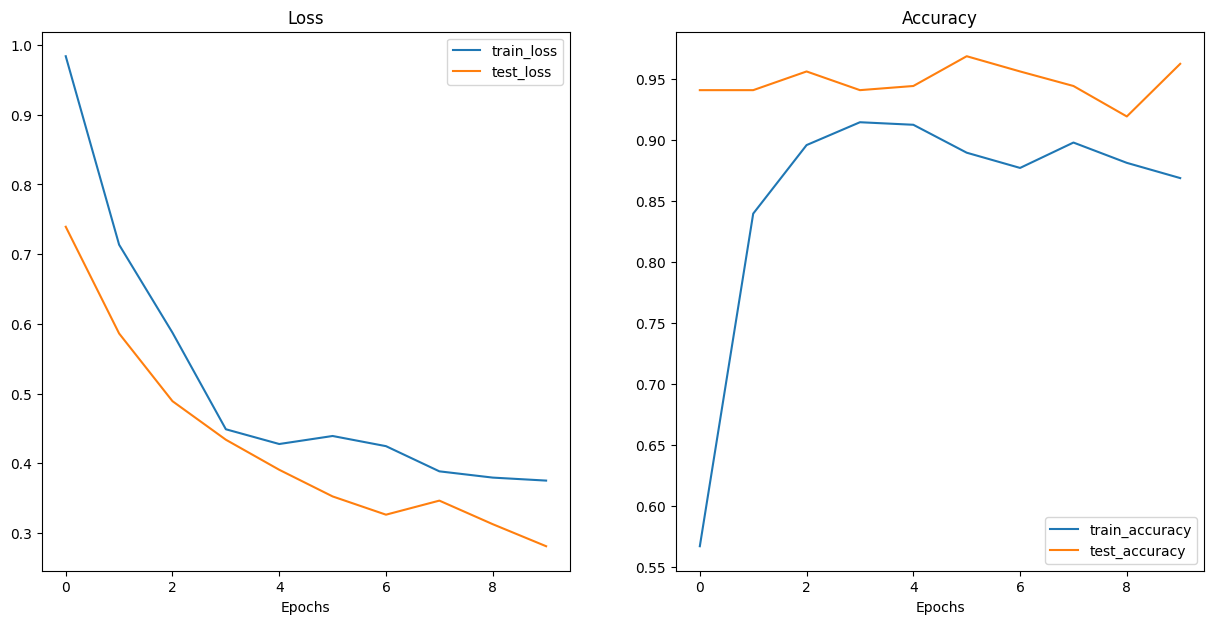

In [10]:
plot_loss_curves(effnetb2_results)

What should an ideal loss curves looks like?

See here - https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg" width="600">







### 3.3 Saving the EffNetB2 model

In [11]:
from going_modular.going_modular import utils

# save the model
utils.save_model(model=effnetb2_model,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [12]:
# inspecting the size of the saved model
from pathlib import Path

effnetb2_model_size = Path("/content/models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model_size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model_size: 29 MB


### 3.4 Collecting EffNetB2 feature extractor stats

In [13]:
effnetb2_total_params = sum(torch.numel(params) for params in effnetb2_model.parameters())
effnetb2_total_params

7705221

In [14]:
# create a dictionary with EffNetB2 statistics
effnetb2_stats = {
    "test_loss": effnetb2_results["test_loss"][-1],
    "test_acc": effnetb2_results["test_acc"][-1],
    "number_of_parameters": effnetb2_total_params,
    "model_size (MB)": effnetb2_model_size
}
effnetb2_stats

{'test_loss': 0.28108683228492737,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 4.0 Creating a ViT feature extractor

In [15]:
def create_vit_model(num_classes:int=3, seed:int=42):
  set_seeds(seed=seed)
  vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  vit = torchvision.models.vit_b_16(weights=vit_weights)

  # freezing the layers
  for params in vit.parameters():
    params.requires_grad = False

  # configuring the classifier head
  vit.heads = nn.Linear(in_features=vit.heads[0].in_features, out_features=num_classes, bias=True)

  # make the classifier head trainable
  vit.heads.requires_grad_(requires_grad=True)

  return vit, vit_weights.transforms()

In [16]:
vit, vit_transforms = create_vit_model(num_classes=3)
summary(model=vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=17,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 218MB/s]


Layer (type (var_name))                                      Input Shape       Output Shape      Param #           Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]  [1, 3]            768               Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]  [1, 768, 14, 14]  (590,592)         False
├─Encoder (encoder)                                          [1, 197, 768]     [1, 197, 768]     151,296           False
│    └─Dropout (dropout)                                     [1, 197, 768]     [1, 197, 768]     --                --
│    └─Sequential (layers)                                   [1, 197, 768]     [1, 197, 768]     --                False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]     [1, 197, 768]     (7,087,872)       False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]     [1, 197, 768]     (7,087,872)       False
│    │    └─EncoderBlock (enc

In [17]:
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### 4.1 Create the dataloader for ViT

In [18]:
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Train the ViT model

In [19]:
%%time
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3)

vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=10,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5522 | train_acc: 0.8479 | test_loss: 0.2232 | test_acc: 0.9625
Epoch: 2 | train_loss: 0.2026 | train_acc: 0.9563 | test_loss: 0.1153 | test_acc: 0.9875
Epoch: 3 | train_loss: 0.1420 | train_acc: 0.9604 | test_loss: 0.0879 | test_acc: 0.9875
Epoch: 4 | train_loss: 0.1218 | train_acc: 0.9688 | test_loss: 0.0751 | test_acc: 0.9938
Epoch: 5 | train_loss: 0.1618 | train_acc: 0.9417 | test_loss: 0.0696 | test_acc: 0.9938
Epoch: 6 | train_loss: 0.0991 | train_acc: 0.9771 | test_loss: 0.0784 | test_acc: 0.9847
Epoch: 7 | train_loss: 0.0760 | train_acc: 0.9854 | test_loss: 0.0685 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0647 | train_acc: 0.9854 | test_loss: 0.0621 | test_acc: 0.9784
Epoch: 9 | train_loss: 0.0573 | train_acc: 0.9875 | test_loss: 0.0601 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0512 | train_acc: 0.9938 | test_loss: 0.0577 | test_acc: 0.9875
CPU times: user 50.8 s, sys: 2.73 s, total: 53.5 s
Wall time: 1min 21s


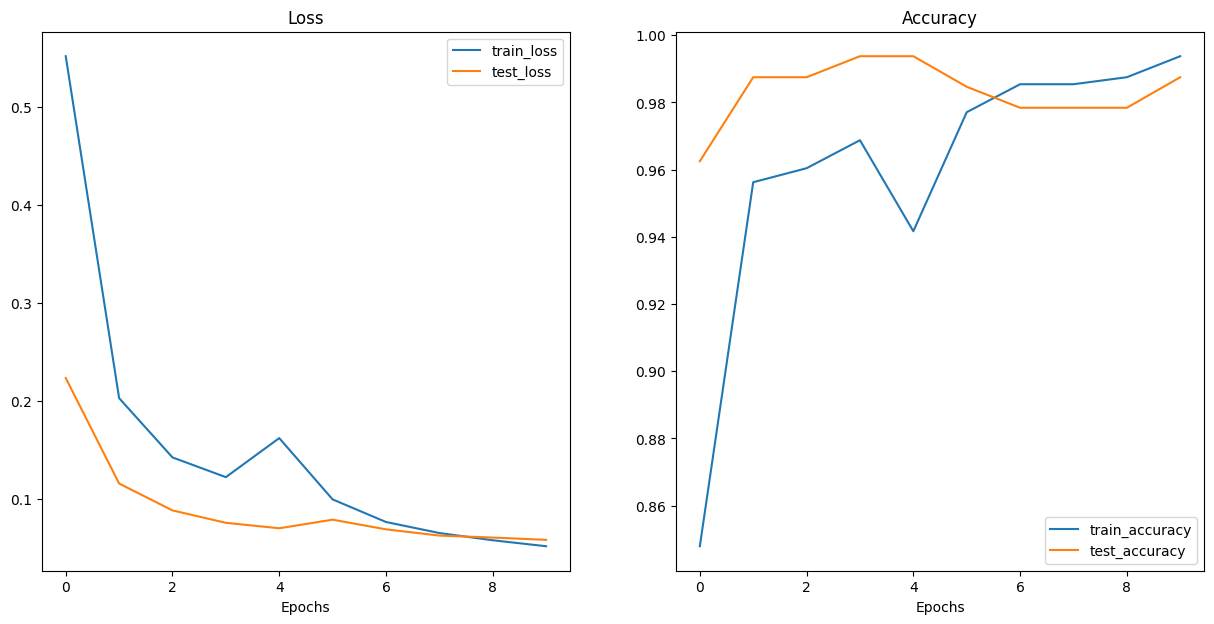

In [20]:
plot_loss_curves(vit_results)

### 4.3 Saving the ViT model

In [21]:
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.4 Ckecking the size of ViT model

In [22]:
vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024 * 1024)
print(f'ViT model size: {vit_model_size} MB')

ViT model size: 327 MB


### 4.4 Collecting ViT models stats

In [23]:
vit_total_params = sum(torch.numel(params) for params in vit.parameters())
vit_total_params

85800963

In [24]:
# create a dictionary with EffNetB2 statistics
vit_stats = {
    "test_loss": vit_results["test_loss"][-1],
    "test_acc": vit_results["test_acc"][-1],
    "number_of_parameters": vit_total_params,
    "model_size (MB)": vit_model_size
}
vit_stats

{'test_loss': 0.05773502248339355,
 'test_acc': 0.9875,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## 5.0 Making predictions with our trained models and timing them

Our goal:

1. Performs well (95%+ test accuracy).
2. Fast (30+FPS)

To test criteria two:

1. Loop through test images.
2. Time how long each model takes to make a prediction on the image.

Let's work twards making a function called `pred_and_store()` to do so.

First we'll need a list of test image paths.

In [25]:
from pathlib import Path

# get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
len(test_data_paths), test_data_paths[:5]

(150,
 [PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1994748.jpg'),
  PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/911808.jpg'),
  PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2819945.jpg'),
  PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/511818.jpg'),
  PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/167716.jpg')])

### 5.1 Creating a function to make across the test dataset

Steps to create `pred_and_store()`:

1. Create a function that takes a list of paths and a trained PyTorch model and a series of transforms a list of target class names and a target device.
2. Create an empty list (can reutrn a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will take place inside the loop).
4. Create an empty dictionary for each sample (prediction statistics will go in here).
5. Get the sample path and ground truth class from the filepath.
6. Start the prediction timer.
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image to be usable with a given model.
9. Prepare the model for inference by sending to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the targte transformed image to the model and perform forward pass + calculate pred prob + pred class.
11. Add the pred prob + pred class to empty dictionary step 4.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
13. See if the predicted class matches the ground truth class.
14. Append the updated prediciton dictionary to the empty list of predictions we created in step 2.
15. Return the list of prediciton dictionaries.

In [26]:
import torch
import pathlib
from typing import List, Dict
from timeit import default_timer as timer
from PIL import Image
from tqdm.auto import tqdm

def pred_and_store(paths:List[pathlib.Path],
                   model:torch.nn.Module,
                   transform:torchvision.transforms,
                   class_names:List[str],
                   device:str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
  pred_list = []

  # loop through each input image path in the image_paths list
  for path in tqdm(paths):
    pred_dict = {}

    pred_dict['image_path'] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    start_time = timer()  # starting the timer

    img = Image.open(path)  # opening the image from the path
    transformed_image = transform(img).unsqueeze(0)  # applying the transformation

    # sending the model and image to the target device
    transformed_image = transformed_image.to(device)
    model = model.to(device)

    # turning on eval mode and making prediction
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item())
      pred_dict["pred_class"] = pred_class

      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time - start_time, 4)

    pred_dict["correct"] = class_name == pred_class
    pred_list.append(pred_dict)

  return pred_list

### 5.2 Making and timing predictions with EffNetB2

Let's test our `pred_and_store()` function.

Two things to note:
1. Device - We're going to hardcore our predictions to happen on CPU (because you won't always be sure of having a GPU when you deploy your model).
2. Transforms - We want to make sure each of the models are predeicting on images that have been prepared with the appropriate transforms (e.g. EffNetB2 with `effnetb2_transforms`)

In [27]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2_model,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [28]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1994748.jpg'),
  'class_name': 'sushi',
  'pred_prob': 1,
  'pred_class': 'sushi',
  'time_for_pred': 0.2847,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/911808.jpg'),
  'class_name': 'sushi',
  'pred_prob': 1,
  'pred_class': 'sushi',
  'time_for_pred': 0.1199,
  'correct': True}]

In [29]:
total_time = 0
for i in range(0, 30):
  total_time += effnetb2_test_pred_dicts[i]['time_for_pred']
total_time

3.6464999999999996

In [30]:
# turn the test_pred_dicts into DataFrame
import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,1,sushi,0.2847,True
1,data/pizza_steak_sushi_20_percent/test/sushi/9...,sushi,1,sushi,0.1199,True
2,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,1,sushi,0.1212,True
3,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,1,sushi,0.1121,True
4,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0,sushi,0.1129,True


In [31]:
# check the number of correct predictions
effnetb2_test_pred_df['correct'].value_counts()

True     144
False      6
Name: correct, dtype: int64

In [32]:
# find the average time per prediciton
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")

EffNetB2 average time per prediction: 0.1218


> **Note:** Prediction times will vary (much like training times) depending on the hardware you're using...so generally the faster your compute (e.g. CPU or GPU), the faster the predictions will happen.

In [33]:
# add time per pred to effnetb2 stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28108683228492737,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.1218}

### 5.3 Making and timing predicitons with ViT

In [34]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [35]:
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,1,sushi,0.7663,True
1,data/pizza_steak_sushi_20_percent/test/sushi/9...,sushi,1,sushi,0.6435,True
2,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,1,sushi,0.5786,True
3,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,1,sushi,0.7693,True
4,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,1,sushi,0.9541,True


In [36]:
# check the number of correct predictions
vit_test_pred_df['correct'].value_counts()

True     148
False      2
Name: correct, dtype: int64

In [37]:
# find the average time per prediciton
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred}")

ViT average time per prediction: 0.6695


In [38]:
# add average time per prediction to ViT stats
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.05773502248339355,
 'test_acc': 0.9875,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.6695}

## 6.0 Comparing model results, prediction time and size

In [39]:
# turn stat dictionary into dataframe
df = pd.DataFrame([effnetb2_stats, vit_stats])
df["model"] = ["EffNetB2", "ViT"]

# convert accuracy into percentages
df["test_acc"] = round(df["test_acc"]*100, 2)
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281087,96.25,7705221,29,0.1218,EffNetB2
1,0.057735,98.75,85800963,327,0.6695,ViT


Which model is better?

* `test_loss` (lower is better) - ViT
* `test_acc` (higher is better) - ViT
* `number_of_parameters` (generally lower is better) - EffNetB2 (if a model has more parameters, it generally takes longer to compute).
  * Sometimer models with higher parameters can still perform fast.
* `model_size (MB)` - EffNetB2 (for our use case of deploying to a mobile device, generally lower is better).
* `time_per_pred_cpu` - EffNetB2 (lower is better, will be highly dependent on the hardware you;re running on).

Both models fail to achieve our goal of 30+FPS...however we could always just try and use EffNetB2 and see how it goes.

In [40]:
# compare ViT tp EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.205399,1.025974,11.135432,11.275862,5.496716


### 6.1 Visualizing the speed vs. performance tradeoff

So we've compared our EffNetB2 and ViT feature extractor models, now let's visualize the comparison with a speed vs. performance plot.

We can do so with matplotlib:

1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
2. Add titles and labels to make our plot look nice.
3. Annotate the samples on the scatter plot so we know what's going on.
4. Create a legend based on the model size (`model_size (MB)`).

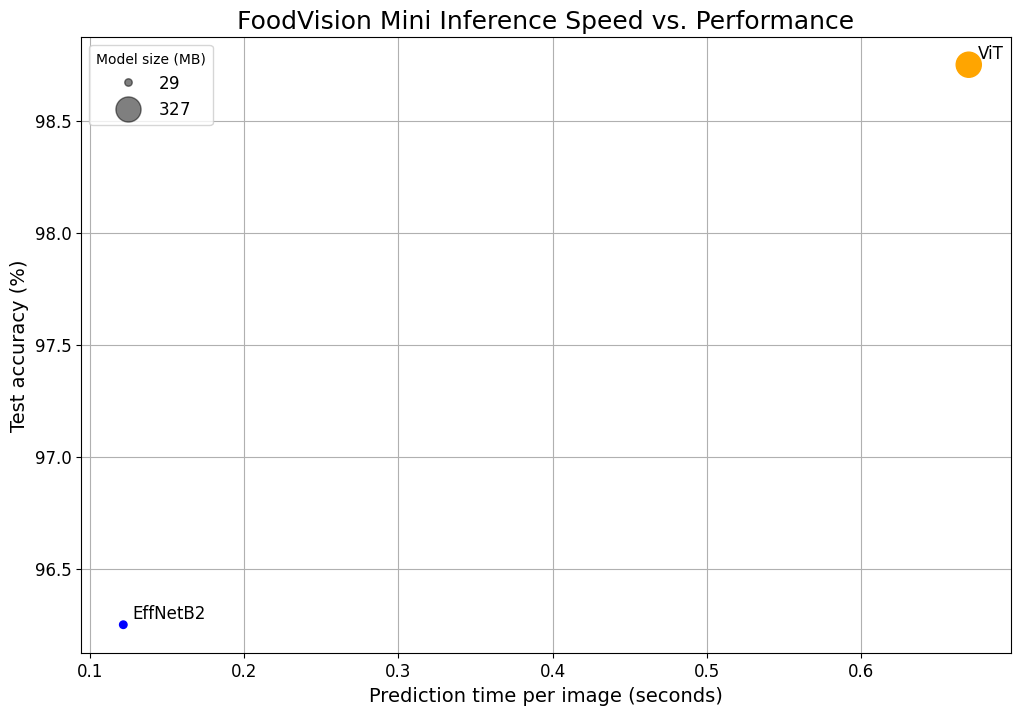

In [41]:
# create a plot from model comparison DataFrame
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")

# add titles and labels
ax.set_title("FoodVision Mini Inference Speed vs. Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

# annotate the samples on the scatter plot so we know what;s going on.
for index, row in df.iterrows():
  ax.annotate(text=row["model"],
              xy=(row["time_per_pred_cpu"] + 0.006, row["test_acc"] + 0.03),
              size=12)

# creating a legend based on the model size
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="upper left",
                              title="Model size (MB)",
                              fontsize=12)

# save the figure
plt.savefig("09-foodvision-mini-inference-speed-vs-performance.png")

There are many ways we can optimize the models inference.

- [PyTorch Performance Tuning Guid](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html)
- [PyTorch ONNX](https://pytorch.org/docs/stable/onnx.html)
- [PyTorch OPENVINO](https://docs.openvino.ai/2023.2/openvino_docs_MO_DG_prepare_model_convert_model_Convert_Model_From_PyTorch.html)